In [41]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse, IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')

## $\omega$ + 100 MHz drive on a single-qubit machine

In [2]:
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[0]

In [3]:
backend_config.dt

2.2222222222222221e-10

In [4]:
backend_defaults.instruction_schedule_map.get('x', [0])

Schedule((0, Play(Drag(duration=160, amp=(0.19599782793610418+0j), sigma=40, beta=-0.5353907901894657, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")

In [5]:
schedules = []
for width in np.arange(0, 4800, 160):
    with pulse.build(backend=backend, default_alignment='sequential', name=f'sched_{width}') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.set_frequency(center_frequency_Hz + 1.e+8, drive_chan)
        pulse.play(pulse.GaussianSquare(duration=int(320 + width), amp=0.9, width=width, sigma=80), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)

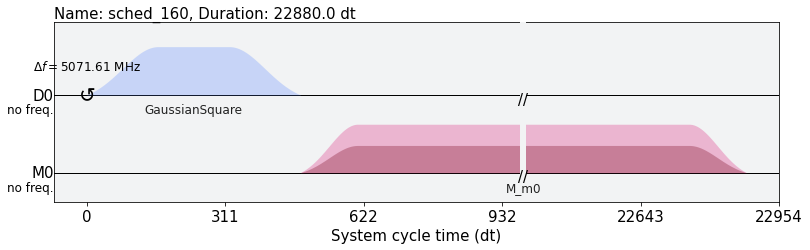

In [6]:
schedules[1].draw()

In [7]:
#job = backend.run(schedules, shots=1000)
job = backend.retrieve_job('620d166461cbfc7a9562ceaa')

In [8]:
result = job.result()

In [9]:
counts = result.get_counts()

In [10]:
counts[0]

{'0': 944, '1': 56}

In [11]:
z_exp = np.array([(cnt.get('0', 0) - cnt.get('1', 0)) / 1000. for cnt in counts])

Text(0, 0.5, '$\\langle Z \\rangle$')

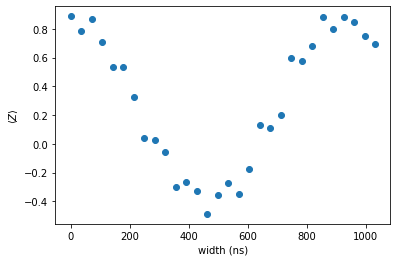

In [13]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0, 4800, 160) * backend_config.dt * 1.e+9, z_exp)
plt.xlabel('width (ns)')
plt.ylabel(r'$\langle Z \rangle$')

## Is the induced term purely X (and that's why we don't see the effect in the echoed CR)?

In [29]:
backend = provider.get_backend('ibmq_jakarta')

backend_config = backend.configuration()
backend_defaults = backend.defaults()

In [30]:
backend_config.dt

2.2222222222222221e-10

In [48]:
backend_defaults.qubit_freq_est

[5236362138.699125,
 5014173141.182169,
 5107736942.314111,
 5178385835.469952,
 5213317328.8157,
 5063220744.880527,
 5299994492.12506]

## Qubits 0 and 1 (200 MHz)

In [71]:
backend_defaults.instruction_schedule_map.get('cx', (0, 1))

Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(2))), (0, ShiftPhase(1.5707963267948966, ControlChannel(2))), (0, Play(Drag(duration=160, amp=(0.09552490152240636+0.0020868074210116006j), sigma=40, beta=-1.0024105921458335, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), (0, Play(Drag(duration=160, amp=(-3.514568991840272e-17-0.1913242247635401j), sigma=40, beta=-1.0159705233060479, name='Ym_d2'), DriveChannel(2), name='Ym_d2')), (160, Play(GaussianSquare(duration=400, amp=(0.11179342138823449+0.007331243933662143j), sigma=64, width=144, name='CR90p_d1_u4'), DriveChannel(1), name='CR90p_d1_u4')), (160, Play(GaussianSquare(duration=400, amp=(-0.8261923077390243+0.08761701374558241j), sigma=64, width=144, name='CR90p_u4'), ControlChannel(4), name='CR90p_u4')), (560, Play(Drag(duration=160, amp=(0.1913242247635401+0j), sigma=40, beta=-1.0159705233060479, name='Xp_d2'), DriveChannel(2), name='Xp_d2')), (720, Play(GaussianSquare(duration=400, amp=(-0.11179342138823449-0.0073312

In [63]:
schedules = []
for width in np.arange(0, 4800, 160):
    with pulse.build(backend=backend, default_alignment='sequential', name=f'sched_single_{width}') as sched:
        control_chan = pulse.control_channels(0, 1)[0]
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(-0.001300154115759826-0.7552526631277313j), sigma=64, width=width))
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)

schedules_echo = []
for width in np.arange(0, 4800, 160):
    with pulse.build(backend=backend, default_alignment='sequential', name=f'sched_single_{width}') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(-0.001300154115759826-0.7552526631277313j), sigma=64, width=width))
        pulse.play(pulse.Drag(duration=160, amp=(0.19766358905233308+0j), sigma=40, beta=-0.9943558024622442, name='Xp_d0'), drive_chan)
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(0.001300154115759826+0.7552526631277313j), sigma=64, width=width))
        pulse.play(pulse.Drag(duration=160, amp=(0.19766358905233308+0j), sigma=40, beta=-0.9943558024622442, name='Xp_d0'), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        
    schedules_echo.append(sched)

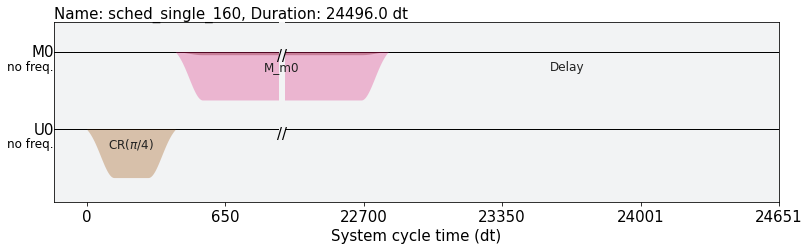

In [51]:
schedules[1].draw()

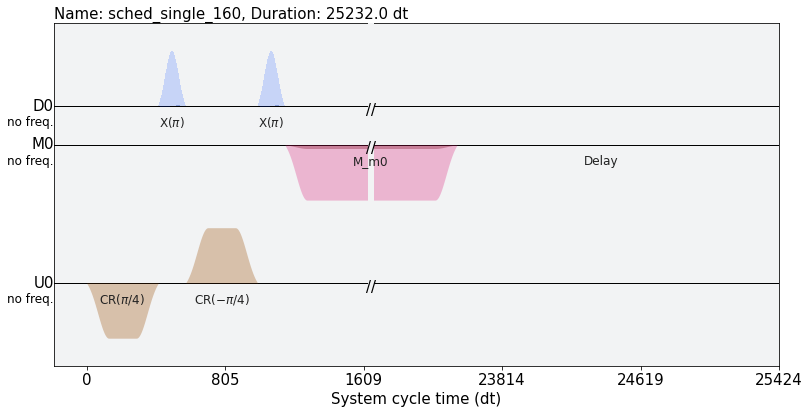

In [66]:
schedules_echo[1].draw()

In [64]:
job = backend.retrieve_job('620de93361cbfc4ee362d1c9')
job_echo = backend.retrieve_job('620def2d89a5f0e638acac1f')

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:450: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Text(0, 0.5, '$\\langle Z \\rangle$')

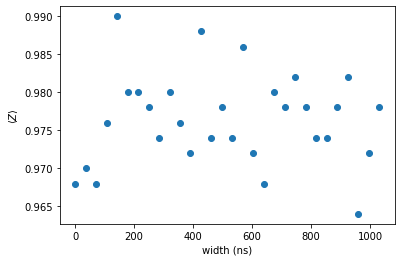

In [60]:
counts = job.result().get_counts()
z_exp = np.array([(cnt.get('0', 0) - cnt.get('1', 0)) / 1000. for cnt in counts])

plt.scatter(np.arange(0, 4800, 160) * backend_config.dt * 1.e+9, z_exp[:30])
plt.xlabel('width (ns)')
plt.ylabel(r'$\langle Z \rangle$')

Text(0, 0.5, '$\\langle Z \\rangle$')

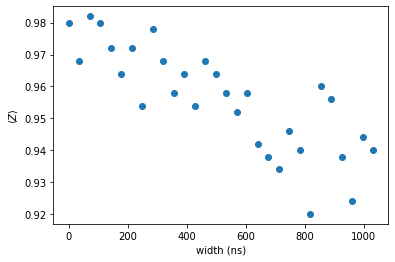

In [65]:
counts_echo = job_echo.result().get_counts()
z_exp = np.array([(cnt.get('0', 0) - cnt.get('1', 0)) / 1000. for cnt in counts_echo])

plt.scatter(np.arange(0, 4800, 160) * backend_config.dt * 1.e+9, z_exp)
plt.xlabel('width (ns)')
plt.ylabel(r'$\langle Z \rangle$')

## Qubits 1 & 2 (100 MHz)

In [74]:
backend_defaults.instruction_schedule_map.get('cx', (2, 1))

Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(2))), (0, ShiftPhase(1.5707963267948966, ControlChannel(2))), (0, Play(Drag(duration=160, amp=(0.09552490152240636+0.0020868074210116006j), sigma=40, beta=-1.0024105921458335, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), (0, Play(Drag(duration=160, amp=(-3.514568991840272e-17-0.1913242247635401j), sigma=40, beta=-1.0159705233060479, name='Ym_d2'), DriveChannel(2), name='Ym_d2')), (160, Play(GaussianSquare(duration=400, amp=(0.11179342138823449+0.007331243933662143j), sigma=64, width=144, name='CR90p_d1_u4'), DriveChannel(1), name='CR90p_d1_u4')), (160, Play(GaussianSquare(duration=400, amp=(-0.8261923077390243+0.08761701374558241j), sigma=64, width=144, name='CR90p_u4'), ControlChannel(4), name='CR90p_u4')), (560, Play(Drag(duration=160, amp=(0.1913242247635401+0j), sigma=40, beta=-1.0159705233060479, name='Xp_d2'), DriveChannel(2), name='Xp_d2')), (720, Play(GaussianSquare(duration=400, amp=(-0.11179342138823449-0.0073312

In [76]:
with pulse.build(backend=backend):
    print(pulse.control_channels(2, 1)[0])

ControlChannel(4)


In [80]:
schedules = []
for width in np.arange(0, 480, 16):
    with pulse.build(backend=backend, default_alignment='sequential', name=f'sched_single_{width}') as sched:
        control_chan = pulse.control_channels(2, 1)[0]
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(-0.8261923077390243+0.08761701374558241j), sigma=64, width=width, name='CR90p_u4'), control_chan, name='CR90p_u4')
        pulse.measure(qubits=[2], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)

for width in np.arange(0, 480, 16):
    with pulse.build(backend=backend, default_alignment='sequential', name=f'sched_single_{width}') as sched:
        drive_chan = pulse.drive_channel(2)
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(-0.8261923077390243+0.08761701374558241j), sigma=64, width=width, name='CR90p_u4'), control_chan, name='CR90p_u4')
        pulse.play(pulse.Drag(duration=160, amp=(0.19766358905233308+0j), sigma=40, beta=-0.9943558024622442, name='Xp_d0'), drive_chan)
        pulse.play(pulse.GaussianSquare(duration=int(256 + width), amp=(0.8261923077390243-0.08761701374558241j), sigma=64, width=width, name='CR90p_u4'), control_chan, name='CR90p_u4')
        pulse.play(pulse.Drag(duration=160, amp=(0.19766358905233308+0j), sigma=40, beta=-0.9943558024622442, name='Xp_d0'), drive_chan)
        pulse.measure(qubits=[2], registers=[pulse.MemorySlot(0)])
        
    schedules.append(sched)

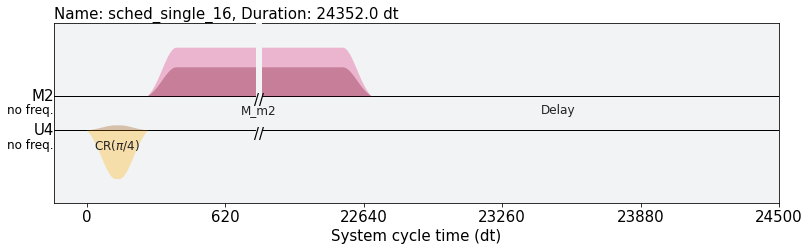

In [81]:
schedules[1].draw()

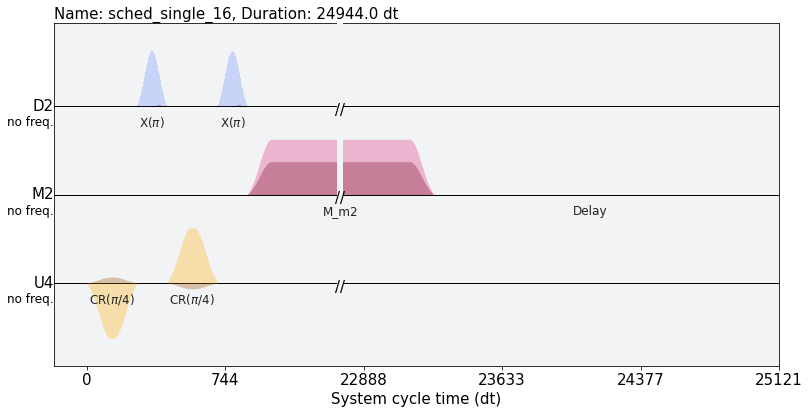

In [82]:
schedules[31].draw()

In [83]:
job = backend.run(schedules, shots=1000)

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:450: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [ ]:
counts = job.result().get_counts()
z_exp = np.array([(cnt.get('0', 0) - cnt.get('1', 0)) / 1000. for cnt in counts])

In [ ]:
plt.scatter(np.arange(0, 4800, 160) * backend_config.dt * 1.e+9, z_exp[:30])
plt.xlabel('width (ns)')
plt.ylabel(r'$\langle Z \rangle$')

In [ ]:
plt.scatter(np.arange(0, 4800, 160) * backend_config.dt * 1.e+9, z_exp[30:])
plt.xlabel('width (ns)')
plt.ylabel(r'$\langle Z \rangle$')